In [1]:
import pyvista as pv
import numpy as np
from src.utils.commons import get_config
from src.utils.split_dataset import split_dataset
from src.data.vtu_to_h5 import vtu_to_h5
import os

config = get_config('configs/default.yaml')['config']

sample_size = config['data_sample']
print(f"Dataset directory: {config['dataset_dir']}")
print(f"Split directory: {config['split_dir']}")
print(f"Sample size: {sample_size}")

train_dir, val_dir, test_dir = split_dataset(data_dir=config['dataset_dir'], 
              split_dir=config['split_dir'], 
              sample_size=sample_size,
              overwrite=False)

Dataset directory: ./dataset/cylinder_vonkarman/Re200_cut/flow
Split directory: ./dataset/cylinder_vonkarman/Re200_cut/flow_split
Sample size: 1000


100%|██████████| 100/100 [00:02<00:00, 41.53it/s]


In [3]:
sample_file = os.listdir(train_dir)[0]

grid = pv.UnstructuredGrid(os.path.join(train_dir, sample_file))
# grid.plot(show_edges=True)
grid.point_data_to_cell_data()

UnstructuredGrid (0x237a54b8a00)
  N Cells:    30846
  N Points:   15677
  X Bounds:   0.000e+00, 8.000e+00
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [4]:
# Get the coordinates of point positions
coordinates = grid.points[:,:2]  # Get x,y coordinates (omit z)
print("Point coordinates shape:", coordinates.shape)


Point coordinates shape: (15677, 2)


In [5]:
grid.points[:,:2]

pyvista_ndarray([[0.      , 0.      ],
                 [8.      , 4.      ],
                 [8.      , 0.      ],
                 ...,
                 [5.511292, 1.570736],
                 [7.931677, 3.55    ],
                 [7.924575, 1.24055 ]])

In [6]:
# Get edges from grid
edges = grid.extract_all_edges()
edge_points = edges.lines.reshape(-1, 3)[1:] # Skip first element which is line count
edge_index = edge_points[:,1:].reshape(2, -1) # Get pairs of connected points
print("Edge index shape:", edge_index.shape)
print("\nFirst few edges:")
print(edge_index.reshape(2, -1))


Edge index shape: (2, 46522)

First few edges:
[[    1     2     2 ... 11101 11101 11174]
 [11174 11074  7398 ...  1779  1556 15626]]


converting vtk to h5

In [7]:
from src.data.vtu_to_h5 import vtu_to_h5
from src.utils.commons import get_config
import os

config = get_config('configs/default.yaml')['config']
splits = ['train', 'val', 'test']
for split in splits:
    vtu_to_h5(os.path.join(config['split_dir'], split), os.path.join(config['split_dir'], f'{split}.h5'), overwrite=True, edge_index=edge_index)

100%|██████████| 800/800 [03:13<00:00,  4.13it/s]


Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\train.h5


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\val.h5


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]

Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\test.h5


In [7]:
import h5py
train_file = h5py.File(os.path.join(config['split_dir'], 'train.h5'), 'r')

In [8]:
file_keys = list(train_file.keys())
file_keys

['coordinates',
 'edge_index',
 'flow_00283',
 'flow_00678',
 'flow_00970',
 'flow_00995',
 'flow_01007',
 'flow_01096',
 'flow_01223',
 'flow_01343',
 'flow_01347',
 'flow_01479',
 'flow_01526',
 'flow_01632',
 'flow_01668',
 'flow_01705',
 'flow_01781',
 'flow_02156']

In [36]:
train_file[file_keys[1]].keys()

<KeysViewHDF5 ['Ux', 'Uy', 'coordinates', 'edge_index']>

In [37]:
ux_field = train_file[file_keys[1]]['Ux']
uy_field = train_file[file_keys[1]]['Ux']
coordinates = train_file[file_keys[1]]['coordinates']

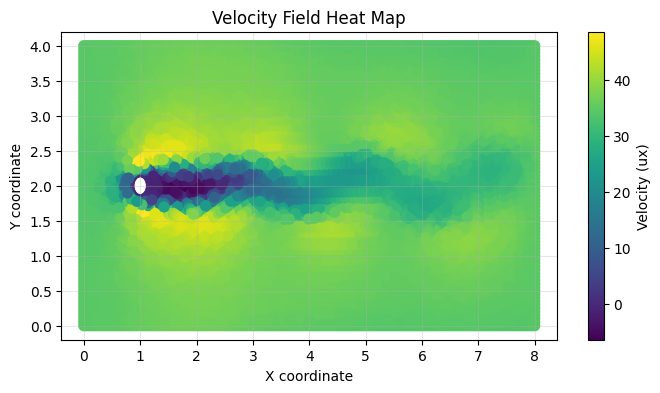

In [38]:
import matplotlib.pyplot as plt
x = np.array([coord[0] for coord in coordinates])
y = np.array([coord[1] for coord in coordinates])

plt.figure(figsize=(8, 4))
scatter = plt.scatter(x, y, 
                     c=ux_field,  # Color based on ux values
                     cmap='viridis',  # You can change this to other colormaps like 'jet', 'hot', etc.
                     s=50)  # Size of the points
# Add a colorbar
plt.colorbar(scatter, label='Velocity (ux)')

# Add labels and title
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Velocity Field Heat Map')

# Make the plot more readable
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()


load mesh

In [9]:
import meshio

config = get_config('configs/default.yaml')['config']

mesh = meshio.read(filename=config['mesh_file'], file_format='vtk')


In [15]:
mesh.cells[2].data

array([[ 9548, 13101,  3747],
       [ 1212, 14983,  1213],
       [ 8977,  9550,  6710],
       ...,
       [15478, 15623,  9497],
       [15613, 15629,  9178],
       [ 9608, 15629, 15613]], dtype=int32)

In [8]:
mesh.cells_dict

{'vertex': array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], dtype=int32),
 'line': array([[  3,   3],
        [  3,   3],
        [  3,   9],
        ...,
        [506, 507],
        [507, 508],
        [508,   7]], dtype=int32),
 'triangle': array([[ 9548, 13101,  3747],
        [ 1212, 14983,  1213],
        [ 8977,  9550,  6710],
        ...,
        [15478, 15623,  9497],
        [15613, 15629,  9178],
        [ 9608, 15629, 15613]], dtype=int32)}

c:\Users\Yuno\anaconda3\envs\'gca_rom'\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


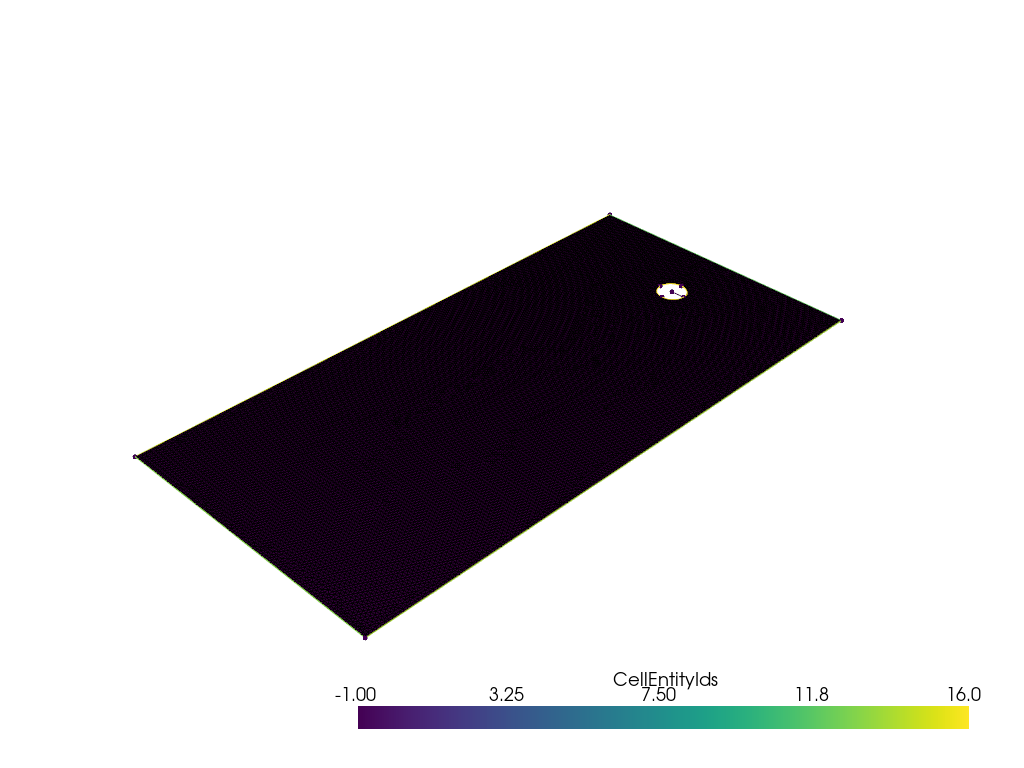

In [ ]:
#plot mesh
import pyvista as pv

# Create a PyVista plotter
plotter = pv.Plotter()

# Add the mesh to the plotter
plotter.add_mesh(mesh, show_edges=True)

# Show the plot
plotter.show()

In [88]:
mesh.points

array([[0.        , 0.        , 0.        ],
       [8.        , 4.        , 0.        ],
       [8.        , 0.        , 0.        ],
       ...,
       [5.51129195, 1.57073571, 0.        ],
       [7.93167654, 3.55      , 0.        ],
       [7.92457525, 1.24054966, 0.        ]])

In [2]:
from src.data.loader import GraphDataset

dataset = GraphDataset()

tensor([[ 3.4326e+01,  9.0210e-03],
        [ 3.4199e+01, -9.3021e-02],
        [ 3.4266e+01,  9.3521e-03],
        ...,
        [ 3.4398e+01, -8.1122e-01],
        [ 3.4385e+01,  9.2174e-02],
        [ 3.5603e+01,  2.6033e+00]])

In [ ]:
np.array(dataset.__getitem__(79).edge_attr)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [2]:
import pyvista as pv

read = pv.read("dataset/rans_naca0012/incompressible/flow/flow_5.vtu")
read

UnstructuredGrid (0x201b31dd960)
  N Cells:    229376
  N Points:   230336
  X Bounds:   -4.845e+02, 5.010e+02
  Y Bounds:   -5.078e+02, 5.078e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   12

c:\Users\Yuno\anaconda3\envs\'gca_rom'\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


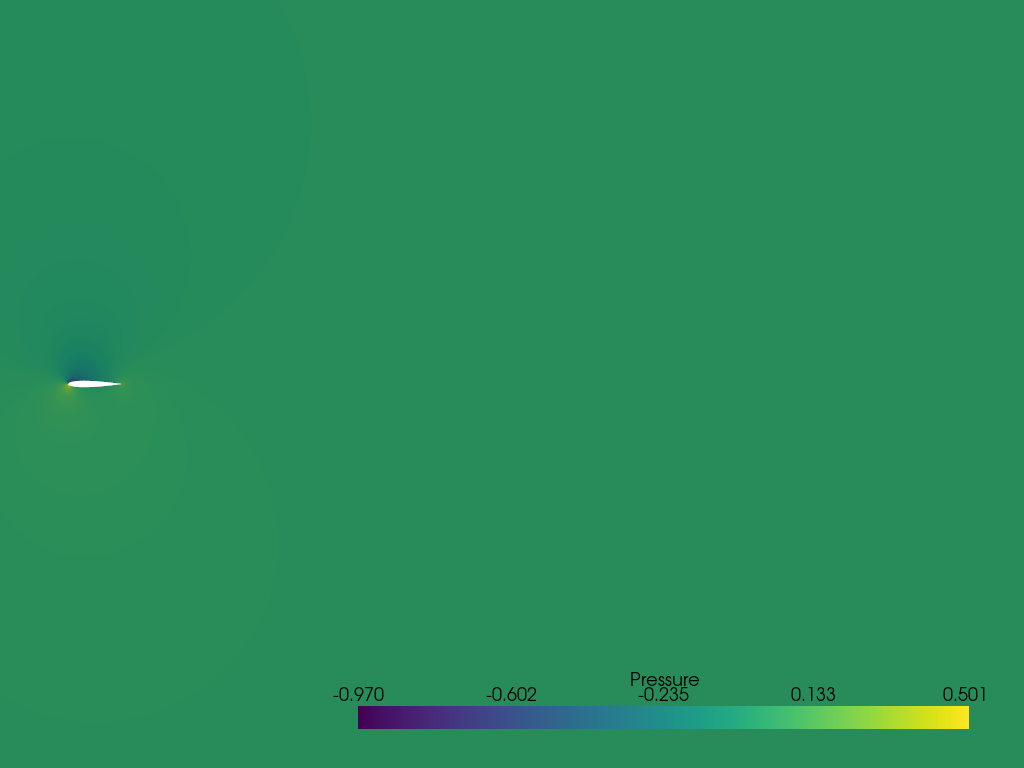

In [10]:
plotter = pv.Plotter()
plotter.add_mesh(read, scalars='Pressure')
plotter.view_xy()
plotter.camera.zoom(100)
plotter.show()